## Generate data from a Gaussian mixture model:
Generate a two-dimensional dataset from a K-component Gaussian mixture density with
different locations (means) and different covariance matrices.


• To do this, for each data point,
1. first, the class label ($z_i$) (the label of the Gaussian component to be generated from it) is
selected according to a  multinomial distribution with parameter vector the mixing
proportions ($pi_1,...pi_K$) which you would also choose
Store the class labels for each generated data point (to perform later comparison)
2. Given the class label ($z_i$), generate a data vector ($x_i$) according to the corresponding
Gaussian component N($\mu_{z_i}$,$\Sigma_{z_i}$)

In [40]:
#import required libraries
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal
from scipy.stats import norm
from sklearn.cluster import KMeans
from matplotlib.patches import Ellipse
import warnings
import random

warnings.filterwarnings('ignore')

In [ ]:
def generate_gmm_2d(K, n_samples, means, covariances, weights, random_state=None):
    """
    Generate 2D Gaussian Mixture Model (GMM) dataset
    
    Parameters:
    
        K (int): Number of Gaussian components
        
        n_samples (int): Total number of samples
        
        means (list of array-like):  List of K mean vectors, each of shape (2,)
        
        covariances (list of array-like): List of K covariance matrices, each of shape (2,2)
        
        weights (array-like): Mixing proportions, shape (K,), must sum to 1
        
        random_state (int):Random seed 
        
    Returns:
        X (np.ndarray):Generated data points, shape (n_samples, 2)

        y (np.ndarray): True class labels, shape (n_samples,)
    """

    
    # === Parameter validation ===
    assert len(means) == K, "Number of means must match K"
    assert len(covariances) == K, "Number of covariances must match K"
    assert np.isclose(np.sum(weights), 1.0), "Sum of weights must be 1"
    np.random.seed(random_state) ,"Fix random seed"

    
    # === 1. Generate class labels from mixing proportions ===
    # Randomly assign component labels based on weights
    
    y = np.random.choice(K, size=n_samples, p=weights)
    
    # 2. === 2. Generate data points from corresponding Gaussians ===
    
    X = np.zeros((n_samples, 2))  # Initialize data matrix
    for k in range(K): #Find indices of samples belonging to component k
        
        indices = np.where(y == k)[0]
        if len(indices) > 0: # Generate data from the k-th Gaussian
           X[indices] = multivariate_normal.rvs(
    mean=means[k], 
    cov=covariances[k], 
    size=len(indices)
)  
    return X, y

In [54]:
def plot_gmm_2d(X, y, means, covariances):
    """
     Visualize 2D GMM data and theoretical distributions
    
    Parameters:
        X (np.ndarray): Data points, shape (n_samples, 2)
        y (np.ndarray): True class labels, shape (n_samples,)
        means (list): List of true mean vectors
        covariances (list):  List of true covariance matrices
    """
    
    plt.figure(figsize=(10, 6))
    colors = ['red', 'blue', 'green', 'purple', 'orange']
    K = len(means) # Number of components
    
    # === Plot data points ===
    for k in range(K):
        plt.scatter(X[y == k, 0], X[y == k, 1], # x and y coordinates
                    c=colors[k], alpha=0.6,   # Color and transparenc
                    label=f'Component {k}', s=30,   # Color and transparenc
                    edgecolor='white'  # Edge color
                   )
    
     # === Plot covariance ellipses ===
    for k in range(K):
        # Compute eigenvalues and eigenvectors
        eigvals, eigvecs = np.linalg.eigh(covariances[k])
        # Compute ellipse rotation angle (radians to degrees)
        angle = np.degrees(np.arctan2(eigvecs[1, 0], eigvecs[0, 0]))
        width, height = 4 * np.sqrt(eigvals)
        # Compute axis lengths (scaled by 4 for visibility)

        # Create ellipse patch
        ellipse = plt.matplotlib.patches.Ellipse(
            xy=means[k],  # Center coordinates
            width=width,
            height=height,
            angle=angle,
            fill=False,
            linestyle='--',
            linewidth=2,
            edgecolor=colors[k]
        )
        plt.gca().add_patch(ellipse)# Add ellipse to the plot

        # Mark the mean with an 'X'
        plt.scatter(means[k][0], means[k][1], 
                    c='black', marker='X', s=200, edgecolor='white')# Large black 'X' marker


    # === Plot styling ===
    plt.title(f'2D GMM Generated Data (K={K})')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.grid(alpha=0.3)  # Semi-transparent grid
    plt.show()

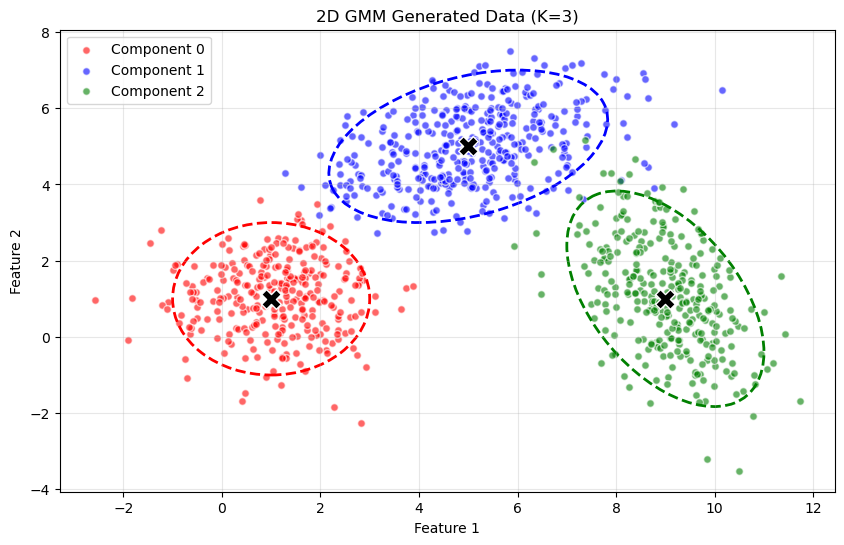

In [51]:
# Usage Example
if __name__ == "__main__":
    #   # ===  Parameter setup ===
    np.random.seed(42)
    K = 3 #  3 Gaussian components
    n_samples = 1000
    means = [
        [1.0, 1.0],    # Mean of component 0
        [5.0, 5.0],    # Mean of component 1
        [9.0, 1.0]     # Mean of component 2
    ]
    covariances = [
        [[1.0, 0.0],   # Corvariance of component 0,Spherical covariance
         [0.0, 1.0]],
        [[2.0, 0.5],   # Corvariance of component 1,Tilted ellipse
         [0.5, 1.0]],
        [[1.0, -0.7],  # Corvariance of component 2,Oppositely tilted ellipse
         [-0.7, 2.0]]
    ]
    weights = [0.3, 0.4, 0.3]  # Mixing proportions
    
     # === Generate data ===
    X, y = generate_gmm_2d(K, n_samples, means, covariances, weights)
    
    
    plot_gmm_2d(X, y, means, covariances)

EM for a GMM

• Implement the EM algorithm to estimate a K-component Gaussian mixture density:

• Initialize the mixing propositions and the covariance matrices (e.g., equal mixing proportions
and Identity covariance matrices)

• Initialize the means locations “randomly” (by your own choice of K vectors from R^d) or
initialize them with standard K-means clustering

• in the EM training loop, store the value of the observed-data log-likelihood at each iteration

• At convergence, plot the log-likelihood curve and plot the estimated density and the
corresponding MAP partition (use the scatter plot, gscatter ..); you may need the function to
draw elipse  densities (function)

In [56]:
def gmm_em(X, K, max_iter=100, tol=1e-6, init_method='random'):
    """
  EM Algorithm for Gaussian Mixture Model Parameter Estimation
    
    Parameters::
        X (np.ndarray):  Input data of shape (n_samples, 2)
        K (int): Number of Gaussian components
        max_iter (int): Maximum iterations
        tol (float): convergence threshold (log-likelihood change)
        init_method (str):Initialization method: 'random' or 'kmeans'
        
    Returns::
        params (dict): Dictionary of estimated parameters:
            - 'weights':  Mixing proportions
            - 'means': Mean vectors
            - 'covs': Covariance matrices
            - 'log_likelihoods': Log-likelihood history
    """
    n_samples, d = X.shape
    
    ######################################################
    # 1. Parameter Initialization
    ######################################################
    # Initialize mixing weights uniformly to make sure every component have the same probability
    weights = np.ones(K) / K
    
    # Mean initialization strategy
    #  Use K-means cluster centers
    if init_method == 'kmeans':
        kmeans = KMeans(n_clusters=K, n_init=10).fit(X)
        means = kmeans.cluster_centers_
    else:
        #  Randomly select data points as initial means
        means = X[np.random.choice(n_samples, K, replace=False)]
    
    #  Initialize covariance matrices as identity matrices
    covs = [np.eye(d) for _ in range(K)]
    
    log_likelihoods = []
    
    ######################################################
    # 2. EM Training Loop 
    ######################################################
    for iteration in range(max_iter):
        ##################################################
        # E-step: Compute Posterior Probabilities ---
        ##################################################
        likelihood = np.zeros((n_samples, K))
        for k in range(K):
            try:
                # Compute likelihood for each component
                likelihood[:, k] = weights[k] * multivariate_normal.pdf(X, mean=means[k], cov=covs[k])
            except np.linalg.LinAlgError:
                #  Handle singular matrix: add regularization
                covs[k] += 1e-6 * np.eye(d)
                likelihood[:, k] = weights[k] * multivariate_normal.pdf(X, mean=means[k], cov=covs[k])
        
        # Compute posterior probabilities (avoid division by zero)
        posterior = likelihood / (likelihood.sum(axis=1, keepdims=True) + 1e-16)
        
        ##################################################
        # M-step: Update Parameters ---
        ##################################################
        
        # Update mixing weights
        Nk = posterior.sum(axis=0)
        weights = Nk / n_samples
        
        # Update mean vectors
        means = np.dot(posterior.T, X) / Nk[:, np.newaxis]
        
        # Update covariance matrices
        covs = []
        for k in range(K):
            diff = X - means[k]
            cov_k = (posterior[:, k] * diff.T) @ diff / Nk[k] # Compute weighted covariance
            cov_k += 1e-6 * np.eye(d)  #  Regularization for positive definiteness
            covs.append(cov_k)
        
        ##################################################
        # Compute Log-Likelihood ---
        ##################################################
        curr_log_likelihood = np.log(likelihood.sum(axis=1) + 1e-16).sum()
        log_likelihoods.append(curr_log_likelihood)
        
        # Check convergence
        if len(log_likelihoods) > 1 and abs(curr_log_likelihood - log_likelihoods[-2]) < tol:
            break
    
    return {
        'weights': weights,
        'means': means,
        'covs': covs,
        'log_likelihoods': log_likelihoods
    }

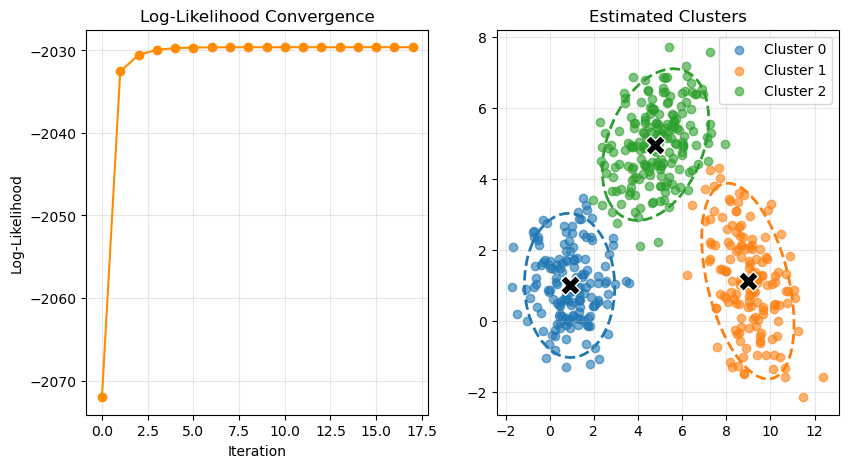

In [58]:

    
def plot_em_results(X, params, true_labels=None):
    """
     Visualize EM Algorithm Results
    
    Parameters:
        X (np.ndarray):  Input data
        params (dict):  EM output parameters
        true_labels (np.ndarray):  True labels (optional)
    """
    plt.figure(figsize=(15, 5))
    K = len(params['means'])
    
    # ===  Subplot 1: Log-Likelihood Convergence ===
    plt.subplot(131)
    plt.plot(params['log_likelihoods'], marker='o', linestyle='-', color='darkorange')
    plt.title('Log-Likelihood Convergence')
    plt.xlabel('Iteration')
    plt.ylabel('Log-Likelihood')
    plt.grid(alpha=0.3)
    
    # ===  Subplot 2: Estimated Clusters ===
    plt.subplot(132)
    #  Compute MAP labels
    likelihood = np.zeros((X.shape[0], K))
    for k in range(K):
        likelihood[:, k] = multivariate_normal.pdf(X, mean=params['means'][k], cov=params['covs'][k])
    map_labels = np.argmax(likelihood, axis=1)
    
    # Plot clustering results
    colors = plt.cm.tab10(np.arange(K))
    for k in range(K):
        plt.scatter(X[map_labels == k, 0], X[map_labels == k, 1], 
                   color=colors[k], alpha=0.6, label=f'Cluster {k}')
        
        # Plot covariance ellipses
        eigvals, eigvecs = np.linalg.eigh(params['covs'][k])
        angle = np.degrees(np.arctan2(eigvecs[1, 0], eigvecs[0, 0]))  #  Compute rotation angle
        width, height = 4 * np.sqrt(eigvals)  #  Ellipse axes lengths
        ellipse = Ellipse(
            xy=params['means'][k],
            width=width,
            height=height,
            angle=angle,
            fill=False,
            linestyle='--',
            linewidth=2,
            edgecolor=colors[k]
        )
        plt.gca().add_patch(ellipse)
        
        # Mark mean points
        plt.scatter(params['means'][k][0], params['means'][k][1],
                   c='black', marker='X', s=200, edgecolor='white')
    
    plt.title('Estimated Clusters')
    plt.legend()
    plt.grid(alpha=0.3)
    
    
# === Usage Example ===
if __name__ == "__main__":
    #  Generate synthetic data
    np.random.seed(42)
    K = 3
    n_samples = 500
    means = [[1,1], [5,5], [9,1]]
    covs = [
        [[1,0], [0,1]],    #  Isotropic
        [[2,0.5], [0.5,1]],  #  Positive correlation
        [[1,-0.7], [-0.7,2]] #  Negative correlation
    ]
    weights = [0.3, 0.4, 0.3]
    X, true_labels = generate_gmm_data(K, n_samples, means, covs, weights)
    
    #  Run EM algorithm
    params = gmm_em(X, K=3, init_method='kmeans')
    
    #  Visualize results
    plot_em_results(X, params, true_labels=true_labels)